## Vector Auto Regression

In [879]:
import numpy as np
import pandas as pd
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from matplotlib import pyplot
import warnings
import math
warnings.filterwarnings("ignore") # Ignore warnings

In [880]:
# Define metrics
# Cited from https://towardsdatascience.com/dynamic-time-warping-3933f25fcdd, https://stats.stackexchange.com/questions/58391/mean-absolute-percentage-error-mape-in-scikit-learn

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def dtw(s, t): # Function where s is 
    n, m = len(s), len(t)
    dtw_matrix = np.zeros((n+1, m+1))
    for i in range(n+1):
        for j in range(m+1):
            dtw_matrix[i, j] = np.inf
    dtw_matrix[0, 0] = 0
    
    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = abs(s[i-1] - t[j-1])
            # take last min from a square box
            last_min = np.min([dtw_matrix[i-1, j], dtw_matrix[i, j-1], dtw_matrix[i-1, j-1]])
            dtw_matrix[i, j] = cost + last_min
    return dtw_matrix

In [881]:
# Read preprocessed train and test data
training_data = pd.read_csv("../../preprocessed_data/mandatory_train.csv")
test_data = pd.read_csv("../../preprocessed_data/mandatory_test.csv")

### Using Predicted Price

In [895]:
trains = training_data[["Time (UTC+10)","Regions VIC Trading Price ($/MWh)","Regions VIC Operational Demand (MW)"]]
tests = test_data[["Time (UTC+10)","Regions VIC Trading Price ($/MWh)","Regions VIC Operational Demand (MW)"]]
trains.set_index(keys = 'Time (UTC+10)', inplace = True)
tests.set_index(keys = 'Time (UTC+10)', inplace = True)
LAG = 52

In [883]:
# Log transformation
def log_transformation(df_name, min_price, min_demand):
    df_name['log_price'] = np.log(df_name['Regions VIC Trading Price ($/MWh)'] + abs(min_price) + 1)
    df_name['log_demand'] = np.log(df_name["Regions VIC Operational Demand (MW)"] + abs(min_demand) + 1)
    df_name['log_price'] = df_name['log_price'] - df_name['log_price'].shift()
    df_name['log_demand'] = df_name['log_demand'] - df_name['log_demand'].shift()
    return df_name.drop(['Regions VIC Trading Price ($/MWh)', 'Regions VIC Operational Demand (MW)'], axis = 1).dropna()

#     df = np.log(df_name[col_name])
#     for i in df.index:
#         if np.isnan(df.loc[i]): # use np.isnan to check if nan !!
#             df.loc[i] = math.log(df_name[col_name].loc[i] + abs(df_name[col_name].min()) + 1)
#         if (math.isinf(df.loc[i])):
#             print('True')
    # return df

In [884]:
min_price = min(trains['Regions VIC Trading Price ($/MWh)'].min(), tests['Regions VIC Trading Price ($/MWh)'].min())
min_demand = min(trains["Regions VIC Operational Demand (MW)"].min(), tests["Regions VIC Operational Demand (MW)"].min())
trains = log_transformation(trains.copy(), min_price, min_demand) # For price & demand
tests = log_transformation(tests.copy(), min_price, min_demand)

In [885]:
trains.columns = ['Regions VIC Trading Price ($/MWh)', "Regions VIC Operational Demand (MW)"]

In [886]:
tests.columns = ['Regions VIC Trading Price ($/MWh)', "Regions VIC Operational Demand (MW)"]

In [887]:
train = trains.values
test = tests.values

In [902]:
# Trains the model, obtain beta hat

def train_model(trains):
    model = VAR(trains)
    print(model)
    model_fitted = model.fit(196)
    # Determines beta hat for Regions VIC Trading Price
    coef = model_fitted.params
    return coef

In [903]:
def predict_model2(train, coef):
    history = train[len(train)-LAG:]
    history = [history[i] for i in range(len(history))]
    prediction_price = list()
    prediction_demand = []
    coef_price = coef['Regions VIC Trading Price ($/MWh)']
    coef_demand = coef['Regions VIC Operational Demand (MW)']
    
    for t in range(len(tests)):
        length = len(history)
        lag = np.array([history[i] for i in range(length-LAG,length)][::-1]).flatten()
        print(lag)
        price_yhat = np.dot(lag, coef_price[1:]) + coef_price[0]
        #demand_yhat = np.dot(lag, coef_demand[1:]) + coef_demand[0]
        obs = test[t]
        prediction_demand.append(price_yhat)
        history.append(obs)

preds = predict_model2(train, coef2)
preds

[ 0.01839179  0.01128963 -0.00984924 -0.03178418 -0.03309164 -0.02664895
  0.03533628 -0.0244488  -0.00181492 -0.02114049 -0.00938484 -0.02148202
 -0.00247189 -0.01260521 -0.0017373  -0.01785956 -0.04552273 -0.01521023
 -0.0178184  -0.00699155 -0.03927811  0.01135954  0.02344736  0.04052842
  0.08495244  0.04084979 -0.05980035  0.04114055  0.00575347  0.0331278
  0.06278757  0.02705943  0.02452458  0.01328966 -0.01802343  0.00887155
  0.03845673 -0.00483693 -0.01260445 -0.00766486  0.00449533 -0.00245589
 -0.02327257 -0.00592099 -0.01251354 -0.02359019 -0.04413749 -0.03401018
  0.01176149 -0.01371698  0.01907375 -0.01329554 -0.0112909  -0.02549763
  0.00230065 -0.0357927  -0.00753949 -0.0252984  -0.00910244 -0.00807802
  0.0078231   0.02487231  0.03530567  0.04590749  0.00129828  0.04353629
  0.02114325  0.05462193  0.00319792  0.05589652  0.02916536  0.03221242
  0.00701999  0.02727953  0.00802568  0.00271216  0.00534761  0.00472814
 -0.0009903  -0.00286821 -0.01564123 -0.00883952  0.

ValueError: shapes (104,) and (394,) not aligned: 104 (dim 0) != 394 (dim 0)

In [904]:
# Predicts data

def predict_model(train, coef2):
    history = train[len(train)-LAG:]
    history = [history[i] for i in range(len(history))]
    predictions = list()

    # Calculates y_hat by multiplying beta hat with the previous (lags) of prices and demands
    for t in range(len(tests)):
        length = len(history)
        lag = np.array([history[i] for i in range(length-LAG,length)][::-1]).flatten()  # the price & demand predictors
        newyhat = np.dot(lag, coef2[1:]) + coef2[0] 
        obs = test[t]
        predictions.append(newyhat)
        history.append(obs)

    tess = [i[0] for i in test]
    tess = (np.exp(tess) - abs(min_price) - 1)
    print(tess)
    predictions = (np.exp(predictions) - abs(min_price) - 1)
    
    rmse = np.sqrt(mean_squared_error(tess, predictions))
    print('Test RMSE: %.3f' % rmse)
    print('Test MAE: {:.3f}'.format(mean_absolute_error(tess, predictions)))
    print('Test MAPE: {:.3f}'.format(mean_absolute_percentage_error(tess, predictions)))
    #print(dtw(tess, predictions))
    return predictions

In [905]:
coef2 = train_model(trains)

In [906]:
print(coef2)

                                          Regions VIC Trading Price ($/MWh)  \
const                                                            -24.576471   
L1.Regions VIC Trading Price ($/MWh)                               0.797793   
L1.Regions VIC Operational Demand (MW)                             0.108488   
L2.Regions VIC Trading Price ($/MWh)                              -0.041836   
L2.Regions VIC Operational Demand (MW)                            -0.136153   
...                                                                     ...   
L194.Regions VIC Operational Demand (MW)                           0.057832   
L195.Regions VIC Trading Price ($/MWh)                            -0.000378   
L195.Regions VIC Operational Demand (MW)                          -0.016641   
L196.Regions VIC Trading Price ($/MWh)                             0.001689   
L196.Regions VIC Operational Demand (MW)                          -0.009170   

                                          Regions V

In [759]:
preds = predict_model(train, coef2)

[-676.31678225 -676.39161796 -676.42340219 ... -676.3543275  -676.37688845
 -676.36708238]
Test RMSE: 0.066
Test MAE: 0.028
Test MAPE: 0.004


In [748]:
tests = (np.exp(tests) - abs(min_price) - 1)

<AxesSubplot:xlabel='Time (UTC+10)'>

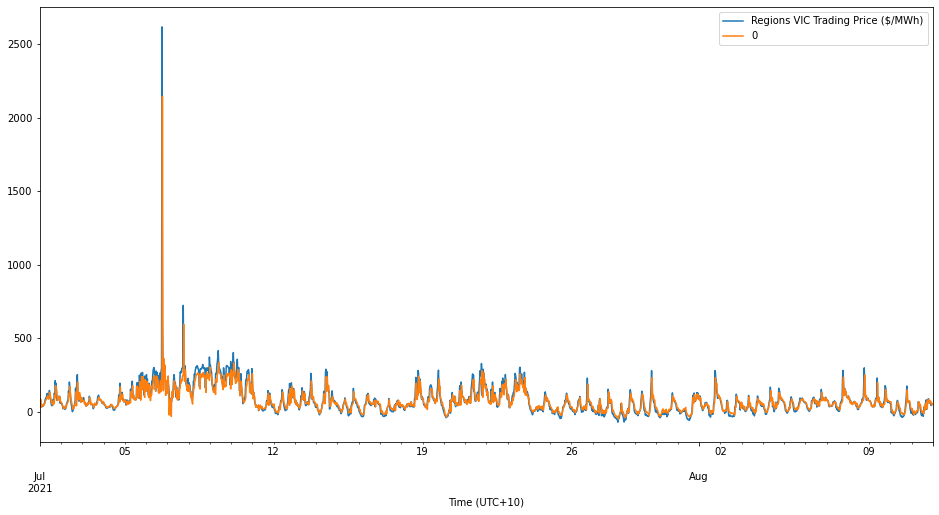

In [749]:
expected = pd.DataFrame(tests, index=tests.index, columns=tests.columns)
forecast = pd.DataFrame(predictions, index=tests.index)
dataframe = pd.concat([ expected["Regions VIC Trading Price ($/MWh)"],forecast[0]], axis=1)
dataframe.index = pd.to_datetime(dataframe.index)
dataframe
dataframe.plot(figsize = (16, 8))

###  --------

### For Regions VIC Trading Price & Regions VIC Operational Demand

In [737]:
trains = training_data[["Time (UTC+10)","Regions VIC Trading Price ($/MWh)","Regions VIC Operational Demand (MW)"]]
tests = test_data[["Time (UTC+10)","Regions VIC Trading Price ($/MWh)","Regions VIC Operational Demand (MW)"]]
trains.set_index(keys = 'Time (UTC+10)', inplace = True)
tests.set_index(keys = 'Time (UTC+10)', inplace = True)
LAG = 52

In [738]:
# Log transformation
def log_transformation(df_name, min_price, min_demand):
    df_name['log_price'] = np.log(df_name['Regions VIC Trading Price ($/MWh)'] + abs(min_price) + 1)
    df_name['log_demand'] = np.log(df_name["Regions VIC Operational Demand (MW)"] + abs(min_demand) + 1)
    return df_name.drop(['Regions VIC Trading Price ($/MWh)', 'Regions VIC Operational Demand (MW)'], axis = 1).dropna()

#     df = np.log(df_name[col_name])
#     for i in df.index:
#         if np.isnan(df.loc[i]): # use np.isnan to check if nan !!
#             df.loc[i] = math.log(df_name[col_name].loc[i] + abs(df_name[col_name].min()) + 1)
#         if (math.isinf(df.loc[i])):
#             print('True')
    # return df

In [739]:
min_price = min(trains['Regions VIC Trading Price ($/MWh)'].min(), tests['Regions VIC Trading Price ($/MWh)'].min())
min_demand = min(trains["Regions VIC Operational Demand (MW)"].min(), tests["Regions VIC Operational Demand (MW)"].min())
trains = log_transformation(trains.copy(), min_price, min_demand) # For price & demand
tests = log_transformation(tests.copy(), min_price, min_demand)

In [740]:
trains

,log_price,log_demand
Time (UTC+10),,
2018-01-01 00:00:00,6.643529,8.871926
2018-01-01 00:30:00,6.646170,8.843326
2018-01-01 01:00:00,6.639863,8.819961
2018-01-01 01:30:00,6.620673,8.801168
2018-01-01 02:00:00,6.616801,8.777401
...,...,...
2021-06-30 21:30:00,6.610911,9.060912
2021-06-30 22:00:00,6.646248,9.036463
2021-06-30 22:30:00,6.613156,9.009814


In [741]:
trains.columns = ['Regions VIC Trading Price ($/MWh)', "Regions VIC Operational Demand (MW)"]

In [742]:
tests.columns = ['Regions VIC Trading Price ($/MWh)', "Regions VIC Operational Demand (MW)"]

In [562]:
# Rename train and test for log transformation, do not run this for w/o log-transform
train = a_b.values
test = c_d.values

In [599]:
trains

,Regions VIC Trading Price ($/MWh),Regions VIC Operational Demand (MW)
Time (UTC+10),,
2018-01-01 00:00:00,90.43,4599
2018-01-01 00:30:00,92.46,4398
2018-01-01 01:00:00,87.62,4238
2018-01-01 01:30:00,73.08,4112
2018-01-01 02:00:00,70.18,3956
...,...,...
2021-06-30 21:30:00,65.79,6082
2021-06-30 22:00:00,92.52,5874
2021-06-30 22:30:00,67.46,5653


In [610]:
a_b.isnull().sum()

Regions VIC Trading Price ($/MWh)      0
Regions VIC Operational Demand (MW)    0
dtype: int64

In [743]:
train = trains.values
test = tests.values

In [744]:
# Trains the model, obtain beta hat

def train_model(trains):
    model = VAR(trains)
    print(model)
    model_fitted = model.fit(52)
    # Determines beta hat for Regions VIC Trading Price
    coef = model_fitted.params
    coef2 = coef['Regions VIC Trading Price ($/MWh)']
    return coef2

In [745]:
# Predicts data

def predict_model(train, coef2):
    history = train[len(train)-LAG:]
    history = [history[i] for i in range(len(history))]
    predictions = list()

    # Calculates y_hat by multiplying beta hat with the previous (lags) of prices and demands
    for t in range(len(tests)):
        length = len(history)
        lag = np.array([history[i] for i in range(length-LAG,length)][::-1]).flatten()  # the price & demand predictors
        newyhat = np.dot(lag, coef2[1:]) + coef2[0] 
        obs = test[t]
        predictions.append(newyhat)
        history.append(obs)

    tess = [i[0] for i in test]
    tess = (np.exp(tess) - abs(min_price) - 1)
    print(tess)
    predictions = (np.exp(predictions) - abs(min_price) - 1)
    
    rmse = np.sqrt(mean_squared_error(tess, predictions))
    print('Test RMSE: %.3f' % rmse)
    print('Test MAE: {:.3f}'.format(mean_absolute_error(tess, predictions)))
    print('Test MAPE: {:.3f}'.format(mean_absolute_percentage_error(tess, predictions)))
    #print(dtw(tess, predictions))
    return predictions

In [746]:
coef2 = train_model(trains)

In [747]:
preds = predict_model(train, coef2)

[51.71 90.51 73.91 ... 54.29 49.25 51.37]
Test RMSE: 62.825
Test MAE: 22.850
Test MAPE: 121.936


In [707]:
preds = predict_model(train, coef2)

[51.71 90.51 73.91 ... 54.29 49.25 51.37]
Test RMSE: 62.825
Test MAE: 22.850
Test MAPE: 121.936


In [708]:
len(preds)

2016

In [666]:
np.exp(preds)

array([inf, inf, inf, ..., inf, inf, inf])

In [709]:
# model_fitted.forecast(test, steps = 52)

In [711]:
tests = (np.exp(tests) - abs(min_price) - 1)

<AxesSubplot:xlabel='Time (UTC+10)'>

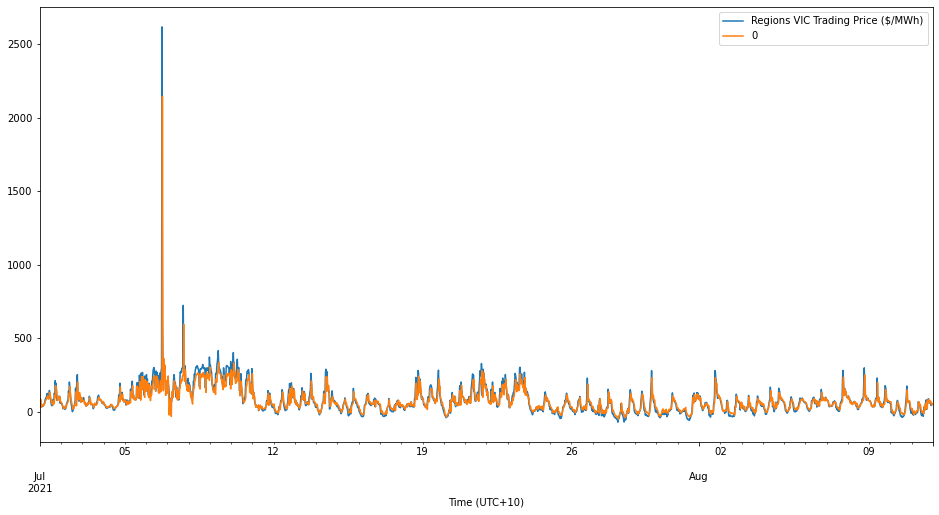

In [712]:
expected = pd.DataFrame(tests, index=tests.index, columns=tests.columns)
forecast = pd.DataFrame(predictions, index=tests.index)
dataframe = pd.concat([ expected["Regions VIC Trading Price ($/MWh)"],forecast[0]], axis=1)
dataframe.index = pd.to_datetime(dataframe.index)
dataframe
dataframe.plot(figsize = (16, 8))

### For Regions VIC Trading Price & Regions NSW Trading Demand

In [388]:
trains = training_data[["Time (UTC+10)","Regions VIC Trading Price ($/MWh)","Regions NSW Trading Price ($/MWh)"]]
tests = test_data[["Time (UTC+10)","Regions VIC Trading Price ($/MWh)","Regions NSW Trading Price ($/MWh)"]]
trains.set_index(keys='Time (UTC+10)', inplace = True)
tests.set_index(keys='Time (UTC+10)', inplace = True)
train = trains.values
test = tests.values

In [389]:
coef3 = train_model(trains)

In [390]:
predict_model(train, coef3)

Test RMSE: 76.574


[73.47925963006693,
 54.199336851897755,
 84.77696874423951,
 82.89047355045689,
 40.29735365745722,
 48.02054785806281,
 52.06032912910521,
 39.76640934879154,
 49.993988924764835,
 36.27654004130791,
 56.504817266670386,
 57.00199755096895,
 64.43513424825585,
 83.08185268615505,
 85.06180992292151,
 87.66208518845241,
 102.24592798706175,
 114.12234779997019,
 117.45597127717505,
 97.83296504158544,
 89.3945504018101,
 90.14341147977248,
 120.24771144343713,
 123.95629399299479,
 101.69529169423178,
 104.27576840331245,
 75.53868533185447,
 47.67985632969156,
 57.65224024064838,
 54.65556348243966,
 48.18796340735743,
 81.51379710652587,
 54.587979991739616,
 83.57563907240245,
 118.8577138147593,
 100.15623978062618,
 190.943938294255,
 162.32779373886194,
 171.48010668664136,
 112.13786023651394,
 90.17641286602262,
 94.94493366228892,
 91.07781517071341,
 86.38567319178735,
 92.92134119940036,
 72.45055017375368,
 94.82709556818479,
 63.94802012893335,
 66.72894501704303,
 66.705

### For Regions VIC Trading Price, Regions VIC Operational Demand &  Regions NSW Trading Price

In [106]:
trains = training_data[["Time (UTC+10)","Regions VIC Trading Price ($/MWh)","Regions VIC Operational Demand (MW)","Regions NSW Trading Price ($/MWh)"]]
tests = test_data[["Time (UTC+10)","Regions VIC Trading Price ($/MWh)","Regions VIC Operational Demand (MW)","Regions NSW Trading Price ($/MWh)"]]
trains.set_index(keys = 'Time (UTC+10)', inplace = True)
tests.set_index(keys = 'Time (UTC+10)', inplace = True)
train = trains.values
test = tests.values

In [107]:
coef4 = train_model(trains)

In [108]:
predict_model(train, coef4)

Test RMSE: 75.601


[95.20695734689426,
 31.200438034842286,
 76.34442588114504,
 82.33229504486727,
 19.481762584076968,
 40.09077728018307,
 45.43844041449646,
 32.883460863245354,
 47.78788721077186,
 25.32866172108138,
 47.73252699470684,
 65.47643894679439,
 59.47352521386845,
 98.2541785024379,
 107.95593871611638,
 100.87071912102621,
 125.91409648746813,
 130.73615677490844,
 107.11961317879084,
 87.54457533476707,
 80.03599770609517,
 71.60297083466381,
 103.32505038828842,
 120.02733720387451,
 92.15882918215559,
 101.52899334519887,
 76.3727031616385,
 48.93966943945069,
 54.11279718755592,
 46.10256309542999,
 60.83894034602233,
 78.83274165631073,
 66.75008223637835,
 113.63700231573429,
 157.41340049392986,
 120.95403628618081,
 254.94968170294342,
 186.68590844614087,
 171.72558109596255,
 120.97641787551655,
 91.67763859566483,
 97.80048057941033,
 91.42077105642957,
 88.64009316934849,
 92.65120369803313,
 68.06197132234493,
 92.76457621888144,
 85.35765162791105,
 71.05393897932086,
 59.

### To-be added
-  <strike>different metrics</strike>
- test on external data ?
- <strike>log trf</strike>

#### Corrected implementation

In [978]:
vic = data[['Time (UTC+10)', 'Regions VIC Trading Price ($/MWh)', 'Regions VIC Operational Demand (MW)']]
vic.columns = ['Time', 'Price', 'Demand']

In [979]:
train_vic = (vic[vic['Time'] < '2021-07-01 00:00:00'])

In [980]:
train_vic

,Time,Price,Demand
0,2018-01-01 00:00:00,90.43,4599
1,2018-01-01 00:30:00,92.46,4398
2,2018-01-01 01:00:00,87.62,4238
3,2018-01-01 01:30:00,73.08,4112
4,2018-01-01 02:00:00,70.18,3956
...,...,...,...
61291,2021-06-30 21:30:00,65.79,6082
61292,2021-06-30 22:00:00,92.52,5874
61293,2021-06-30 22:30:00,67.46,5653
61294,2021-06-30 23:00:00,60.16,5397


In [1075]:
test_vic = vic[(vic['Time'] >= '2021-07-01 00:00:00') & (vic['Time'] <= '2021-08-11 23:30:00')]
len(test_vic)

2016

In [982]:
def calculate_estimate(df_name, param):
    
    # Add lags
    df = pd.DataFrame()
    df[param] = df_name[param].copy()
    for i in range(1, 197): 
        for cols in ['Price', 'Demand']:
            df[f'{cols}_-{i}'] = df_name[cols].shift(i)
    df = df.dropna().reset_index(drop = True)
    
    y = df[param].to_numpy()
    del df[param]
    df.insert(0, 'intercept', 1)

    # Converts df to numpy arrays
    X = df.to_numpy()

    # Calculates beta hat = (X^T.X)^-1 * X^T.Y
    b = np.matmul(np.linalg.inv(np.matmul(X.T, X)), np.matmul(X.T, y))
    b
    
    return df, b

In [983]:
df_price, b_price = calculate_estimate(train_vic, 'Price')

In [984]:
# Df price = Df demand
df_demand, b_demand = calculate_estimate(train_vic, 'Demand')

In [1076]:
df_price

,intercept,Price_-1,Demand_-1,Price_-2,Demand_-2,Price_-3,Demand_-3,Price_-4,Demand_-4,Price_-5,...,Price_-192,Demand_-192,Price_-193,Demand_-193,Price_-194,Demand_-194,Price_-195,Demand_-195,Price_-196,Demand_-196
0,1,61.50,4262.0,75.22,4371.0,78.06,4501.0,114.52,4727.0,81.61,...,70.18,3956.0,73.08,4112.0,87.62,4238.0,92.46,4398.0,90.43,4599.0
1,1,57.48,4147.0,61.50,4262.0,75.22,4371.0,78.06,4501.0,114.52,...,67.43,3833.0,70.18,3956.0,73.08,4112.0,87.62,4238.0,92.46,4398.0
2,1,55.34,4067.0,57.48,4147.0,61.50,4262.0,75.22,4371.0,78.06,...,66.31,3749.0,67.43,3833.0,70.18,3956.0,73.08,4112.0,87.62,4238.0
3,1,56.63,4018.0,55.34,4067.0,57.48,4147.0,61.50,4262.0,75.22,...,67.72,3702.0,66.31,3749.0,67.43,3833.0,70.18,3956.0,73.08,4112.0
4,1,56.06,3976.0,56.63,4018.0,55.34,4067.0,57.48,4147.0,61.50,...,65.50,3688.0,67.72,3702.0,66.31,3749.0,67.43,3833.0,70.18,3956.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61095,1,67.14,6266.0,74.16,6457.0,76.02,6571.0,77.33,6735.0,112.48,...,78.28,5837.0,76.92,5911.0,81.09,6048.0,88.83,6149.0,61.54,6313.0
61096,1,65.79,6082.0,67.14,6266.0,74.16,6457.0,76.02,6571.0,77.33,...,58.99,5662.0,78.28,5837.0,76.92,5911.0,81.09,6048.0,88.83,6149.0
61097,1,92.52,5874.0,65.79,6082.0,67.14,6266.0,74.16,6457.0,76.02,...,59.38,5506.0,58.99,5662.0,78.28,5837.0,76.92,5911.0,81.09,6048.0
61098,1,67.46,5653.0,92.52,5874.0,65.79,6082.0,67.14,6266.0,74.16,...,52.66,5347.0,59.38,5506.0,58.99,5662.0,78.28,5837.0,76.92,5911.0


In [ ]:
# Do log tranformation

In [1079]:
# For test data in row 1:, we predict these using the predicted price for the testing period + the price from training period

def predict(df, b_price, b_demand, test_vic):
    for i in range(len(test_vic)):
        y = df.tail(1).squeeze().tolist()
        betaprice_hat = np.dot(np.array(y), b_price)
        betademand_hat = np.dot(np.array(y), b_demand)
        y.pop()
        y.pop()
        y.insert(1, betademand_hat)
        y.insert(1, betaprice_hat)
        next_predictors = pd.DataFrame(y).T
        next_predictors.columns = df.columns
        df = df.append(next_predictors, ignore_index = True)
    
    return df

In [1080]:
df = predict(df_price, b_price, b_demand, test_vic)

In [1081]:
df

,intercept,Price_-1,Demand_-1,Price_-2,Demand_-2,Price_-3,Demand_-3,Price_-4,Demand_-4,Price_-5,...,Price_-192,Demand_-192,Price_-193,Demand_-193,Price_-194,Demand_-194,Price_-195,Demand_-195,Price_-196,Demand_-196
0,1.0,61.500000,4262.000000,75.220000,4371.000000,78.060000,4501.000000,114.520000,4727.000000,81.610000,...,70.180000,3956.000000,73.080000,4112.000000,87.620000,4238.000000,92.460000,4398.000000,90.430000,4599.000000
1,1.0,57.480000,4147.000000,61.500000,4262.000000,75.220000,4371.000000,78.060000,4501.000000,114.520000,...,67.430000,3833.000000,70.180000,3956.000000,73.080000,4112.000000,87.620000,4238.000000,92.460000,4398.000000
2,1.0,55.340000,4067.000000,57.480000,4147.000000,61.500000,4262.000000,75.220000,4371.000000,78.060000,...,66.310000,3749.000000,67.430000,3833.000000,70.180000,3956.000000,73.080000,4112.000000,87.620000,4238.000000
3,1.0,56.630000,4018.000000,55.340000,4067.000000,57.480000,4147.000000,61.500000,4262.000000,75.220000,...,67.720000,3702.000000,66.310000,3749.000000,67.430000,3833.000000,70.180000,3956.000000,73.080000,4112.000000
4,1.0,56.060000,3976.000000,56.630000,4018.000000,55.340000,4067.000000,57.480000,4147.000000,61.500000,...,65.500000,3688.000000,67.720000,3702.000000,66.310000,3749.000000,67.430000,3833.000000,70.180000,3956.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63111,1.0,85.134773,5341.727160,92.346433,5401.592228,97.934199,5445.933630,102.785480,5469.908881,108.908466,...,77.722505,5288.876123,85.628709,5361.679998,93.412701,5427.061523,99.396461,5476.281791,104.711956,5504.279580
63112,1.0,77.901256,5274.652006,85.134773,5341.727160,92.346433,5401.592228,97.934199,5445.933630,102.785480,...,72.534972,5206.823085,77.722505,5288.876123,85.628709,5361.679998,93.412701,5427.061523,99.396461,5476.281791
63113,1.0,73.036683,5198.889754,77.901256,5274.652006,85.134773,5341.727160,92.346433,5401.592228,97.934199,...,67.204654,5108.996885,72.534972,5206.823085,77.722505,5288.876123,85.628709,5361.679998,93.412701,5427.061523
63114,1.0,68.033597,5109.089946,73.036683,5198.889754,77.901256,5274.652006,85.134773,5341.727160,92.346433,...,62.431949,5031.336761,67.204654,5108.996885,72.534972,5206.823085,77.722505,5288.876123,85.628709,5361.679998


In [1083]:
# Select testing period
test_period = df.loc[61100:]

In [1093]:
pred_test = []
for i in test_period.index:
    yhat = np.dot(test_period.loc[i].to_numpy(), b_price)
    pred_test.append(yhat)
len(pred_test)

2016

In [1091]:
# Actual
actual = test_vic['Price']
len(actual)

2016

In [1088]:
np.sqrt(np.sum((actual-pred_test)**2) / len(actual))

96.9317255918692

#### *Manual VAR() to check*

In [865]:
data = pd.read_excel("../../raw_data/market_data.xlsx")

In [866]:
vic_only = data[['Time (UTC+10)', 'Regions VIC Trading Price ($/MWh)', 'Regions VIC Trading Total Intermittent Generation (MW)', 'Regions VIC Operational Demand (MW)']]

In [867]:
vic = data[['Time (UTC+10)', 'Regions VIC Trading Price ($/MWh)', 'Regions VIC Operational Demand (MW)']]
vic.columns = ['Time', 'Price', 'Demand']

In [868]:
vic

,Time,Price,Demand
0,2018-01-01 00:00:00,90.43,4599
1,2018-01-01 00:30:00,92.46,4398
2,2018-01-01 01:00:00,87.62,4238
3,2018-01-01 01:30:00,73.08,4112
4,2018-01-01 02:00:00,70.18,3956
...,...,...,...
63452,2021-08-14 22:00:00,49.93,5492
63453,2021-08-14 22:30:00,62.86,5344
63454,2021-08-14 23:00:00,32.26,5204
63455,2021-08-14 23:30:00,25.10,5268


In [869]:
vic[(vic['Time'] >= '2021-07-01 00:00:00') & (vic['Time'] <= '2021-08-11 23:30:00')]

,Time,Price,Demand
61296,2021-07-01 00:00:00,51.71,5410
61297,2021-07-01 00:30:00,90.51,5192
61298,2021-07-01 01:00:00,73.91,5016
61299,2021-07-01 01:30:00,33.79,4837
61300,2021-07-01 02:00:00,43.57,4661
...,...,...,...
63307,2021-08-11 21:30:00,61.52,5911
63308,2021-08-11 22:00:00,43.00,5695
63309,2021-08-11 22:30:00,54.29,5450
63310,2021-08-11 23:00:00,49.25,5269


In [870]:
# Add lags
df = pd.DataFrame()
df['Price'] = vic['Price'].copy()
for cols in ['Price', 'Demand']:
    for i in range(1, 197): # 147 lags
        df[f'{cols}_-{i}'] = vic[cols].shift(i)

In [871]:
df_train = df.loc[0:61295]
df_train = df_train.dropna().reset_index(drop = True)
df_train

,Price,Price_-1,Price_-2,Price_-3,Price_-4,Price_-5,Price_-6,Price_-7,Price_-8,Price_-9,...,Demand_-187,Demand_-188,Demand_-189,Demand_-190,Demand_-191,Demand_-192,Demand_-193,Demand_-194,Demand_-195,Demand_-196
0,57.48,61.50,75.22,78.06,114.52,81.61,63.21,64.97,67.90,71.57,...,3700.0,3688.0,3702.0,3749.0,3833.0,3956.0,4112.0,4238.0,4398.0,4599.0
1,55.34,57.48,61.50,75.22,78.06,114.52,81.61,63.21,64.97,67.90,...,3701.0,3700.0,3688.0,3702.0,3749.0,3833.0,3956.0,4112.0,4238.0,4398.0
2,56.63,55.34,57.48,61.50,75.22,78.06,114.52,81.61,63.21,64.97,...,3721.0,3701.0,3700.0,3688.0,3702.0,3749.0,3833.0,3956.0,4112.0,4238.0
3,56.06,56.63,55.34,57.48,61.50,75.22,78.06,114.52,81.61,63.21,...,3731.0,3721.0,3701.0,3700.0,3688.0,3702.0,3749.0,3833.0,3956.0,4112.0
4,53.90,56.06,56.63,55.34,57.48,61.50,75.22,78.06,114.52,81.61,...,3786.0,3731.0,3721.0,3701.0,3700.0,3688.0,3702.0,3749.0,3833.0,3956.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61095,65.79,67.14,74.16,76.02,77.33,112.48,126.68,158.89,139.51,72.98,...,5366.0,5394.0,5347.0,5506.0,5662.0,5837.0,5911.0,6048.0,6149.0,6313.0
61096,92.52,65.79,67.14,74.16,76.02,77.33,112.48,126.68,158.89,139.51,...,5132.0,5366.0,5394.0,5347.0,5506.0,5662.0,5837.0,5911.0,6048.0,6149.0
61097,67.46,92.52,65.79,67.14,74.16,76.02,77.33,112.48,126.68,158.89,...,4945.0,5132.0,5366.0,5394.0,5347.0,5506.0,5662.0,5837.0,5911.0,6048.0
61098,60.16,67.46,92.52,65.79,67.14,74.16,76.02,77.33,112.48,126.68,...,4788.0,4945.0,5132.0,5366.0,5394.0,5347.0,5506.0,5662.0,5837.0,5911.0


In [872]:
df_test = df.loc[61296:63311]
df_test

,Price,Price_-1,Price_-2,Price_-3,Price_-4,Price_-5,Price_-6,Price_-7,Price_-8,Price_-9,...,Demand_-187,Demand_-188,Demand_-189,Demand_-190,Demand_-191,Demand_-192,Demand_-193,Demand_-194,Demand_-195,Demand_-196
61296,51.71,73.85,60.16,67.46,92.52,65.79,67.14,74.16,76.02,77.33,...,4342.0,4548.0,4788.0,4945.0,5132.0,5366.0,5394.0,5347.0,5506.0,5662.0
61297,90.51,51.71,73.85,60.16,67.46,92.52,65.79,67.14,74.16,76.02,...,4216.0,4342.0,4548.0,4788.0,4945.0,5132.0,5366.0,5394.0,5347.0,5506.0
61298,73.91,90.51,51.71,73.85,60.16,67.46,92.52,65.79,67.14,74.16,...,4142.0,4216.0,4342.0,4548.0,4788.0,4945.0,5132.0,5366.0,5394.0,5347.0
61299,33.79,73.91,90.51,51.71,73.85,60.16,67.46,92.52,65.79,67.14,...,4066.0,4142.0,4216.0,4342.0,4548.0,4788.0,4945.0,5132.0,5366.0,5394.0
61300,43.57,33.79,73.91,90.51,51.71,73.85,60.16,67.46,92.52,65.79,...,4033.0,4066.0,4142.0,4216.0,4342.0,4548.0,4788.0,4945.0,5132.0,5366.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63307,61.52,70.00,62.06,59.77,60.96,89.42,84.83,83.47,71.94,18.29,...,5397.0,5455.0,5409.0,5472.0,5587.0,5740.0,5838.0,5932.0,6113.0,6235.0
63308,43.00,61.52,70.00,62.06,59.77,60.96,89.42,84.83,83.47,71.94,...,5199.0,5397.0,5455.0,5409.0,5472.0,5587.0,5740.0,5838.0,5932.0,6113.0
63309,54.29,43.00,61.52,70.00,62.06,59.77,60.96,89.42,84.83,83.47,...,4980.0,5199.0,5397.0,5455.0,5409.0,5472.0,5587.0,5740.0,5838.0,5932.0
63310,49.25,54.29,43.00,61.52,70.00,62.06,59.77,60.96,89.42,84.83,...,4824.0,4980.0,5199.0,5397.0,5455.0,5409.0,5472.0,5587.0,5740.0,5838.0


In [873]:
y = df_train['Price'].to_numpy()
del df_train['Price']

In [874]:
df_train.insert(0, 'intercept', 1)

In [875]:
df_train

,intercept,Price_-1,Price_-2,Price_-3,Price_-4,Price_-5,Price_-6,Price_-7,Price_-8,Price_-9,...,Demand_-187,Demand_-188,Demand_-189,Demand_-190,Demand_-191,Demand_-192,Demand_-193,Demand_-194,Demand_-195,Demand_-196
0,1,61.50,75.22,78.06,114.52,81.61,63.21,64.97,67.90,71.57,...,3700.0,3688.0,3702.0,3749.0,3833.0,3956.0,4112.0,4238.0,4398.0,4599.0
1,1,57.48,61.50,75.22,78.06,114.52,81.61,63.21,64.97,67.90,...,3701.0,3700.0,3688.0,3702.0,3749.0,3833.0,3956.0,4112.0,4238.0,4398.0
2,1,55.34,57.48,61.50,75.22,78.06,114.52,81.61,63.21,64.97,...,3721.0,3701.0,3700.0,3688.0,3702.0,3749.0,3833.0,3956.0,4112.0,4238.0
3,1,56.63,55.34,57.48,61.50,75.22,78.06,114.52,81.61,63.21,...,3731.0,3721.0,3701.0,3700.0,3688.0,3702.0,3749.0,3833.0,3956.0,4112.0
4,1,56.06,56.63,55.34,57.48,61.50,75.22,78.06,114.52,81.61,...,3786.0,3731.0,3721.0,3701.0,3700.0,3688.0,3702.0,3749.0,3833.0,3956.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61095,1,67.14,74.16,76.02,77.33,112.48,126.68,158.89,139.51,72.98,...,5366.0,5394.0,5347.0,5506.0,5662.0,5837.0,5911.0,6048.0,6149.0,6313.0
61096,1,65.79,67.14,74.16,76.02,77.33,112.48,126.68,158.89,139.51,...,5132.0,5366.0,5394.0,5347.0,5506.0,5662.0,5837.0,5911.0,6048.0,6149.0
61097,1,92.52,65.79,67.14,74.16,76.02,77.33,112.48,126.68,158.89,...,4945.0,5132.0,5366.0,5394.0,5347.0,5506.0,5662.0,5837.0,5911.0,6048.0
61098,1,67.46,92.52,65.79,67.14,74.16,76.02,77.33,112.48,126.68,...,4788.0,4945.0,5132.0,5366.0,5394.0,5347.0,5506.0,5662.0,5837.0,5911.0


In [876]:
# Converts df to numpy arrays
X = df_train.to_numpy()
X

array([[1.000e+00, 6.150e+01, 7.522e+01, ..., 4.238e+03, 4.398e+03,
        4.599e+03],
       [1.000e+00, 5.748e+01, 6.150e+01, ..., 4.112e+03, 4.238e+03,
        4.398e+03],
       [1.000e+00, 5.534e+01, 5.748e+01, ..., 3.956e+03, 4.112e+03,
        4.238e+03],
       ...,
       [1.000e+00, 9.252e+01, 6.579e+01, ..., 5.837e+03, 5.911e+03,
        6.048e+03],
       [1.000e+00, 6.746e+01, 9.252e+01, ..., 5.662e+03, 5.837e+03,
        5.911e+03],
       [1.000e+00, 6.016e+01, 6.746e+01, ..., 5.506e+03, 5.662e+03,
        5.837e+03]])

In [877]:
# Calculates beta hat = (X^T.X)^-1 * X^T.Y
b = np.matmul(np.linalg.inv(np.matmul(X.T, X)), np.matmul(X.T, y))

In [878]:
# This is equivalent to model.params
b

array([-2.45764713e+01,  7.97792934e-01, -4.18364312e-02,  2.58434303e-02,
        3.26358242e-02,  3.82767960e-03,  1.75330864e-02, -1.43062798e-03,
       -3.07909886e-02, -2.14834233e-02,  1.72830230e-03, -4.68404188e-02,
        2.91871845e-02,  6.26608461e-03,  6.93949449e-03,  3.67755216e-03,
        6.62714182e-03, -1.50812948e-03, -2.74767908e-03, -4.04102876e-04,
        7.52536084e-03,  2.03982084e-03, -8.36889531e-03, -3.10469484e-03,
        3.55146802e-03, -1.91438281e-03, -9.36008053e-03, -1.58848959e-02,
       -2.19337878e-02,  1.00013571e-01, -2.78378193e-02, -5.93721474e-03,
        9.45729882e-03,  1.90707689e-03, -3.23379764e-03, -3.03920542e-03,
        3.28713658e-04,  2.15975822e-03,  2.97369941e-02, -4.17525527e-02,
       -8.96354682e-02,  1.38702908e-01, -1.23466861e-02, -2.31675515e-02,
        4.89810996e-02, -6.04791985e-02,  8.29369550e-03,  7.85624602e-02,
        1.30068245e-02, -5.96065291e-02, -4.08489529e-02,  5.05872574e-03,
        2.38129388e-02, -

In [416]:
# Predict train data
pred = []
for i in df_train.index:
    yhat = np.dot(df_train.loc[i].to_numpy(), b) # Multiplies each rows by b
    pred.append(yhat)

In [417]:
# Calculates RMSE
np.sqrt(np.sum((y-pred)**2) / len(y))

170.4504886454001

In [418]:
# Calculates R^2
np.corrcoef(pred, list(y))**2

array([[1.       , 0.6640086],
       [0.6640086, 1.       ]])

In [419]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(y, pred))

170.4504886454001

In [420]:
# Predict test data
df_test

,Price,Price_-1,Price_-2,Price_-3,Price_-4,Price_-5,Price_-6,Price_-7,Price_-8,Price_-9,...,Demand_-137,Demand_-138,Demand_-139,Demand_-140,Demand_-141,Demand_-142,Demand_-143,Demand_-144,Demand_-145,Demand_-146
61296,51.71,73.85,60.16,67.46,92.52,65.79,67.14,74.16,76.02,77.33,...,4280.0,4310.0,4407.0,4593.0,4742.0,4879.0,5052.0,5190.0,5209.0,5163.0
61297,90.51,51.71,73.85,60.16,67.46,92.52,65.79,67.14,74.16,76.02,...,4223.0,4280.0,4310.0,4407.0,4593.0,4742.0,4879.0,5052.0,5190.0,5209.0
61298,73.91,90.51,51.71,73.85,60.16,67.46,92.52,65.79,67.14,74.16,...,4274.0,4223.0,4280.0,4310.0,4407.0,4593.0,4742.0,4879.0,5052.0,5190.0
61299,33.79,73.91,90.51,51.71,73.85,60.16,67.46,92.52,65.79,67.14,...,4322.0,4274.0,4223.0,4280.0,4310.0,4407.0,4593.0,4742.0,4879.0,5052.0
61300,43.57,33.79,73.91,90.51,51.71,73.85,60.16,67.46,92.52,65.79,...,4529.0,4322.0,4274.0,4223.0,4280.0,4310.0,4407.0,4593.0,4742.0,4879.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63307,61.52,70.00,62.06,59.77,60.96,89.42,84.83,83.47,71.94,18.29,...,4789.0,4918.0,5070.0,5104.0,5035.0,5203.0,5433.0,5616.0,5807.0,5931.0
63308,43.00,61.52,70.00,62.06,59.77,60.96,89.42,84.83,83.47,71.94,...,4653.0,4789.0,4918.0,5070.0,5104.0,5035.0,5203.0,5433.0,5616.0,5807.0
63309,54.29,43.00,61.52,70.00,62.06,59.77,60.96,89.42,84.83,83.47,...,4509.0,4653.0,4789.0,4918.0,5070.0,5104.0,5035.0,5203.0,5433.0,5616.0
63310,49.25,54.29,43.00,61.52,70.00,62.06,59.77,60.96,89.42,84.83,...,4416.0,4509.0,4653.0,4789.0,4918.0,5070.0,5104.0,5035.0,5203.0,5433.0


In [421]:
y_2 = df_test['Price'].to_numpy()
del df_test['Price']

In [422]:
len(b)

293

In [423]:
df_test.insert(0, 'intercept', 1)

In [424]:
tests

,Regions VIC Trading Price ($/MWh),Regions NSW Trading Price ($/MWh)
Time (UTC+10),,
2021-07-01 00:00:00,51.71,73.25
2021-07-01 00:30:00,90.51,190.22
2021-07-01 01:00:00,73.91,79.17
2021-07-01 01:30:00,33.79,68.24
2021-07-01 02:00:00,43.57,72.64
...,...,...
2021-08-11 21:30:00,61.52,57.50
2021-08-11 22:00:00,43.00,42.11
2021-08-11 22:30:00,54.29,55.27


In [425]:
b

array([-3.24839962e+01,  7.98092089e-01, -4.18479203e-02,  2.61191523e-02,
        3.28443111e-02,  3.81210108e-03,  1.75310818e-02, -1.18960278e-03,
       -3.10195616e-02, -2.14213221e-02,  1.94400526e-03, -4.68344646e-02,
        2.92738246e-02,  6.19087535e-03,  7.10069100e-03,  3.61944515e-03,
        6.68311731e-03, -1.43054869e-03, -2.77181853e-03, -6.92056821e-04,
        7.66234425e-03,  2.01505647e-03, -8.28672484e-03, -3.42910640e-03,
        3.90824881e-03, -2.16686293e-03, -9.14060046e-03, -1.61464538e-02,
       -2.15858445e-02,  9.97911040e-02, -2.77336230e-02, -5.98665539e-03,
        9.59226633e-03,  1.70431896e-03, -3.24307063e-03, -2.87038734e-03,
        1.91440403e-04,  2.10424960e-03,  2.96937531e-02, -4.15370946e-02,
       -8.93900876e-02,  1.38476972e-01, -1.24161266e-02, -2.29779175e-02,
        4.90194255e-02, -6.04297330e-02,  8.43755391e-03,  7.84129881e-02,
        1.30622747e-02, -5.96175571e-02, -4.06519173e-02,  5.21600905e-03,
        2.38195265e-02, -

In [426]:
pred_test = []
for i in df_test.index:
    yhat = np.dot(df_test.loc[i].to_numpy(), b)
    pred_test.append(yhat)
len(pred_test)

2016

In [427]:
np.sqrt(np.sum((y_2-pred_test)**2) / len(y_2))

71.50595716643384